In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# adjusted mean and std
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [3]:
# Download and load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Download and load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Define the classes for CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


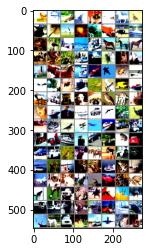

bird  plane car   plane cat   deer  horse bird  deer  cat   plane frog  frog  truck bird  ship  frog  bird  plane deer  truck horse horse horse horse bird  frog  car   truck cat   dog   bird  deer  truck horse ship  ship  plane frog  plane plane frog  deer  truck bird  plane truck ship  deer  truck truck dog   dog   bird  dog   cat   cat   ship  bird  ship  car   bird  frog  bird  cat   frog  bird  plane plane ship  car   dog   dog   truck ship  bird  car   bird  frog  car   car   car   bird  deer  horse dog   horse bird  car   deer  ship  bird  frog  ship  frog  deer  plane cat   dog   frog  bird  car   frog  frog  cat   bird  car   frog  horse cat   deer  deer  truck car   bird  cat   bird  car   ship  bird  deer  dog   car   deer  car   plane cat   truck


In [4]:
# visulaize some of the training images

batch_size = 128

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
# Define the device to be used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class MobileNet(ImageClassificationBase):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        def conv_dw(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [8]:
model = MobileNet()

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)
to_device(model, device);

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
model = to_device(MobileNet(), device)

In [14]:
evaluate(model, testloader)

{'val_loss': 2.302664041519165, 'val_acc': 0.10096914321184158}

In [15]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [16]:
import time
start_time = time.time()

In [17]:
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

Epoch [0], train_loss: 1.7682, val_loss: 1.4676, val_acc: 0.4577
Epoch [1], train_loss: 1.4260, val_loss: 1.2694, val_acc: 0.5330
Epoch [2], train_loss: 1.2305, val_loss: 1.0638, val_acc: 0.6215
Epoch [3], train_loss: 1.0745, val_loss: 0.9355, val_acc: 0.6665
Epoch [4], train_loss: 0.9535, val_loss: 0.8771, val_acc: 0.6900
Epoch [5], train_loss: 0.8574, val_loss: 0.7750, val_acc: 0.7245
Epoch [6], train_loss: 0.7830, val_loss: 0.7187, val_acc: 0.7497
Epoch [7], train_loss: 0.7136, val_loss: 0.6774, val_acc: 0.7647
Epoch [8], train_loss: 0.6649, val_loss: 0.6376, val_acc: 0.7781
Epoch [9], train_loss: 0.6236, val_loss: 0.6065, val_acc: 0.7875


In [18]:
elapsed_time = time.time() - start_time
elapsed_time

166.4911561012268

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

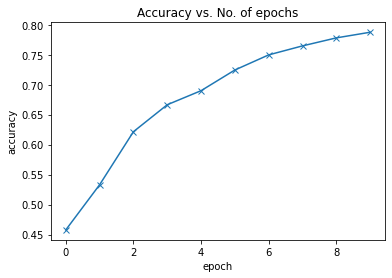

In [20]:
plot_accuracies(history)

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

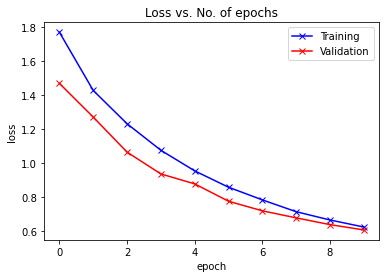

In [22]:
plot_losses(history)

In [23]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

Total Trainable Params: 3217226


3217226